# **Import các thư viện :**

In [1]:
!pip install --upgrade tensorflow==2.16.1
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

In [2]:
#Import các thư viện xử lý ảnh :
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tifffile as tiff
from glob import glob
import seaborn as sns 
import albumentations as albu
from skimage.io import imread
from tqdm import tqdm
import gc


#Tensorflow Imports :
import tensorflow as tf
import tensorflow.keras as k
import keras
from tensorflow import reduce_sum
from tensorflow.keras.utils import Sequence , normalize , img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Layer,
                                    Conv2DTranspose, MaxPool2D, MaxPooling2D, Dropout,
                                    Flatten, Activation, Concatenate, UpSampling2D,
                                    BatchNormalization , MaxPooling2D,
                                    Add, Multiply, Lambda, GlobalAveragePooling2D, 
                                    GlobalMaxPooling2D, Reshape, Dense, LeakyReLU)

from tensorflow.keras.losses import binary_crossentropy
from keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import AdamW, RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
from keras.callbacks import CSVLogger


#Sklearn Import :
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_score

# **Xây dựng các thành phần của mô hình :**

In [3]:
kernel_initializer = 'he_uniform'

#Booster Block :
def Booster_Block(x, num_filters):
    #x shape :
    x_shape = K.int_shape(x)
    
    #Shortcut :
    if x_shape[3] == num_filters :
        shortcut = x
    else :
        shortcut = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
        shortcut = BatchNormalization()(shortcut)
        shortcut = Activation('relu')(shortcut)

        shortcut = Conv2D(num_filters, (3, 3), padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        shortcut = Activation('relu')(shortcut)

    #State 1 :
    x1 = x 
    #Triple Inverted Residual Block :
    for _ in range(3) :
        x1 = Inverted_Residual_Block(x1, num_filters, expansion=4)
    
    #State 2 :
    x2 = Add()([x1, shortcut])
    #Triple Residual Block :
    for _ in range(3) :
        x2 = Residual_Block(x2, num_filters)
        
    #State 3 :
    x3 = Add()([x1, x2, shortcut])
    #Triple Bottleneck Residual Block :
    for _ in range(3) :
        x3 = Bottleneck_Residual_Block(x3, num_filters, expansion=4)
    
    output = Add()([x1, x2, x3, shortcut])
    
    return output

#Bottle Neck Residual Block :
def Bottleneck_Residual_Block(x, num_filters, expansion=4):
    #x shape :
    x_shape = K.int_shape(x)
    
    #Shortcut :
    if x_shape[3] == num_filters :
        shortcut = x
    else :
        shortcut = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
        shortcut = BatchNormalization()(shortcut)
    
    #Residual :
    x = Conv2D(num_filters//expansion, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters//expansion, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    #Add
    output = Add()([x, shortcut])
    
    #Activation :
    output = Activation('relu')(output)

    return output
    
#Residual Block :
def Residual_Block(x, num_filters):
    #x shape :
    x_shape = K.int_shape(x)
    
    #Shortcut :
    if x_shape[3] == num_filters :
        shortcut = x
    else :
        shortcut = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
        shortcut = BatchNormalization()(shortcut)
    
    #Residual :
    x = Conv2D(num_filters, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    #Add
    output = Add()([x, shortcut])
    
    #Activation :
    output = Activation('relu')(output)
    
    return output

def Inverted_Residual_Block(x, num_filters, expansion=4):
    #x shape :
    x_shape = K.int_shape(x)
    
    #Shortcut :
    if x_shape[3] == num_filters :
        shortcut = x
    else :
        shortcut = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
        shortcut = BatchNormalization()(shortcut)
    
    #Residual :
    x = Conv2D(num_filters*expansion, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters*expansion, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    #Add
    output = Add()([x, shortcut])
    
    #Activation :
    output = Activation('relu')(output)
    
    return output

In [4]:
def Wide_Vision_Block(x, num_filters): 
    #Conv 1x1 :
    x = Conv2D(num_filters, (1, 1), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Conv 3x3 :
    x = Conv2D(num_filters, (3, 3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Conv 5x5 :
    x = Conv2D(num_filters, (5, 5), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #DownSample :
    output = MaxPooling2D((2,2))(x)

    return output


def Scale_Down(x, pre_w, num_filters, first_sc=False):
    if first_sc :
        boost = Booster_Block(x, num_filters)    
    else :
        add = Add()([x, pre_w])
        boost = Booster_Block(add, num_filters)    
    
    #DownSample :
    down = MaxPooling2D((2,2))(boost)

    return boost, down
    
def Scale_Up(x, s, num_filters):
    #Reisize :
    res = UpSampling2D((2,2), interpolation='bilinear')(x)
    
    add = Add()([s, res])
    
    boost = Booster_Block(add, num_filters)    

    return boost

# **Xây dựng mô hình :**

In [5]:
def Booster_Net(input_shape=(256, 256, 3), num_classes=1, start_filters=32):
    input_layer = Input(shape=input_shape)
    
    #Deep Conv : 
    w_1 = Wide_Vision_Block(input_layer, start_filters)
    w_2 = Wide_Vision_Block(w_1, start_filters * 2)    
    w_3 = Wide_Vision_Block(w_2, start_filters * 4)    
    w_4 = Wide_Vision_Block(w_3, start_filters * 8)
    w_5 = Wide_Vision_Block(w_4, start_filters * 16)    
    
    #Scale Down State :
    #State 1 : 
    sd_1, down_1 = Scale_Down(input_layer, None,start_filters, first_sc=True) 
    
    #State 2 :     
    sd_2, down_2 = Scale_Down(down_1, w_1, start_filters*2) 
    
    #State 3 :
    sd_3, down_3 = Scale_Down(down_2, w_2, start_filters*4) 
    
    #State 4 :     
    sd_4, down_4 = Scale_Down(down_3, w_3, start_filters*8) 
    
    #State 5 :
    sd_5, down_5 = Scale_Down(down_4, w_4, start_filters*16) 
    
    #Brigde :
    brigde_1 = Add()([down_5, w_5])
    
    for _ in range(2):
        brigde_1 = Residual_Block(brigde_1, start_filters*32)
    
    brigde_2 = brigde_1
    for _ in range(2):
        brigde_2 = Residual_Block(brigde_2, start_filters*16)
    
    #Scale Up State :
    #State 1 :  
    su_1 = Scale_Up(brigde_2, sd_5, start_filters*8)
    
    #State 2 : 
    su_2 = Scale_Up(su_1, sd_4, start_filters*4)
    
    #State 3: 
    su_3 = Scale_Up(su_2, sd_3, start_filters*2)

    #State 4: 
    su_4 = Scale_Up(su_3, sd_2, start_filters)
    
    #State 5: 
    su_5 = Scale_Up(su_4, sd_1, start_filters)
    
    #Output : 
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(su_5)

    #Model :
    model = Model(inputs=input_layer, outputs=outputs, name='Booster_Net')
    
    return model

# **Xây dựng các hàm Loss và Metrics :**

In [6]:
def Dice_Coef(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return ((2. * intersection + smooth) / (union + smooth))

def Dice_Loss(y_true, y_pred):
    return 1 - Dice_Coef(y_true, y_pred)

# **Tiến hành xây dựng các hàm đọc và xử lý dữ liệu ảnh :**

In [7]:
def load_data(img_height, img_width, path):
    IMAGES_PATH = path + '/images/'
    MASKS_PATH = path + '/masks/'

    ids = glob(IMAGES_PATH + "*.jpg")

    num_images = len(ids)
    X = np.zeros((num_images, img_height, img_width, 3), dtype=np.float32)
    Y = np.zeros((num_images, img_height, img_width), dtype=np.float32)

    for n, id_ in tqdm(enumerate(ids), total=num_images):
        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        #Resize image
        pillow_image = Image.fromarray(image)
        pillow_image = pillow_image.resize((img_width, img_height))
        image = np.array(pillow_image)

        X[n] = image / 255.0  #Normalize image

        #Resize mask
        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_width, img_height), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        if mask_.ndim == 3 and mask_.shape[2] > 1:
            mask = (np.mean(mask_, axis=-1) >= 127).astype(np.float32)
        else:
            mask = (mask_ >= 127).astype(np.float32)

        Y[n] = mask

    Y = np.expand_dims(Y, axis=-1)

    return X, Y

#Defining the augmentations :
aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images(x_train, y_train):
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        aug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(aug['image'])  
        y_train_out.append(aug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [8]:
test = 0.1
seed = 101
img_size = 256

#Load Data : 
X, Y = load_data(img_size, img_size, '/kaggle/input/kvasir-segmentation/Kvasir-SEG')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test, shuffle= True, random_state = seed)

100%|██████████| 1000/1000 [00:31<00:00, 31.83it/s]


# **Khởi tạo mô hình :**

In [9]:
model = Booster_Net(input_shape=(256, 256, 3), num_classes=1, start_filters = 8)
model.summary()

Model: "Booster_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │         96 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      9,216 │ activation_17[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │        256 │ activation_18[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 256, 256,  │         24 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 8)                │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │        256 │ activation_19[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      9,216 │ activation_20[0]

 Total params: 17,983,013 (68.60 MB)

 Trainable params: 17,947,277 (68.46 MB)

 Non-trainable params: 35,736 (139.59 KB)

# **Compile cho model đã khởi tạo :**

In [10]:
#Tạo optimizer:
EPOCHS = 600
learning_rate = 3e-4

#Tạo optimizer :
optimizer = RMSprop(learning_rate = learning_rate
                 )

#Compile mô hình :
model.compile(loss=Dice_Loss,
              optimizer=optimizer,
              metrics=[Dice_Coef])

# **Tiến hành training mô hình :**

In [11]:
model_path = 'Booster_Net.keras'

In [12]:
step = 0
min_loss_for_saving = 0.12
metric = -1
epoch_save_weight = -1
for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch+1}/{EPOCHS}')
    print('='*50)
            
    image_augmented, mask_augmented = augment_images(x_train, y_train)
        
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=8, 
              validation_data=None, verbose=1)
    
    prediction = model.predict(x_test, batch_size=8, verbose=0)
    loss = Dice_Loss(y_test, prediction)
    
    loss = loss.numpy()
    metric_t = (1 - loss) * 100 
    print(f"Metric Test : {metric_t:.4f}%")
    print("Loss Test : " + str(loss))
    print('='*50)

    if min_loss_for_saving > loss:
        min_loss_for_saving = loss
        epoch_save_weight = epoch+1
        metric = (1 - min_loss_for_saving) * 100
        print("Saved model with min loss: ", loss)
        model.save(model_path)
        print('='*50)
    
    if epoch_save_weight > 0 :
        print(f'Save model from epoch {epoch_save_weight} with metric {metric:.4f}%')
        print('='*50)

    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 1/600


I0000 00:00:1724223398.553259      80 service.cc:145] XLA service 0x7d4758003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724223398.553306      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724223532.408025      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - dice__coef: 0.3480 - loss: 0.6520
Metric Test : 44.9389%
Loss Test : 0.550611
Training, epoch 2/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - dice__coef: 0.4231 - loss: 0.5769
Metric Test : 29.5190%
Loss Test : 0.70481
Training, epoch 3/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 263ms/step - dice__coef: 0.4644 - loss: 0.5356
Metric Test : 43.4314%
Loss Test : 0.56568617
Training, epoch 4/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - dice__coef: 0.4586 - loss: 0.5414
Metric Test : 51.8648%
Loss Test : 0.4813522
Training, epoch 5/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 263ms/step - dice__coef: 0.5008 - loss: 0.4992
Metric Test : 42.8652%
Loss Test : 0.5713482
Training, epoch 6/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - dice__coef: 0.5146 - loss: 0.4854
Metric Test : 53.1690%
Loss Test : 0.46830976
Training, epoch 7/600
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - dice__coef: 0.5185 - loss: 0.4814
Metric Test : 51.8258%
Loss Test : 0.4817

# **Phân đoạn ảnh dựa trên mô hình đã training :**

In [13]:
#Reload the best model :
path = '/kaggle/working/' + model_path

model = tf.keras.models.load_model(
    path, custom_objects={'Dice_Coef': Dice_Coef, 'Dice_Loss' : Dice_Loss}
)

In [14]:
print("Prediction")
print("=" *50)
y_pred = model.predict(x_test, batch_size=8, verbose=0)
y_pred_b = (y_pred >= 0.5).astype(np.float32)

Prediction


**Hiển thị kết quả phân đoạn (Dice Coeficent, Jacard, Accuracy) :**

In [15]:
dice_scores = []
jaccard_scores = []
accuracy_scores = []
y_true = y_true_thr = y_test

for i in range(len(y_test)) :
    
    flattened_labels = K.flatten(y_true_thr[i])
    flattened_predictions = K.flatten(y_pred_b[i])
    
    #Tính Dice Coefficient và Jaccard Index :
    dice_scores.append(Dice_Coef(y_true[i], y_pred[i]))
    jaccard_scores.append(jaccard_score(flattened_labels, flattened_predictions))

    #Tính Accuracy :
    accuracy_scores.append(accuracy_score(flattened_labels, flattened_predictions))

#In ra kết quả :
print(f"Dice Coefficient Mean: {np.mean(dice_scores)*100}%")
print(f"Jaccard Index Mean: {np.mean(jaccard_scores)*100}%")
print(f"Accuracy Mean: {np.mean(accuracy_scores)*100}%")

Dice Coefficient Mean: 92.0373022556305%
Jaccard Index Mean: 86.4497673280647%
Accuracy Mean: 97.42584228515625%


**Trực quan hoá metric :**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


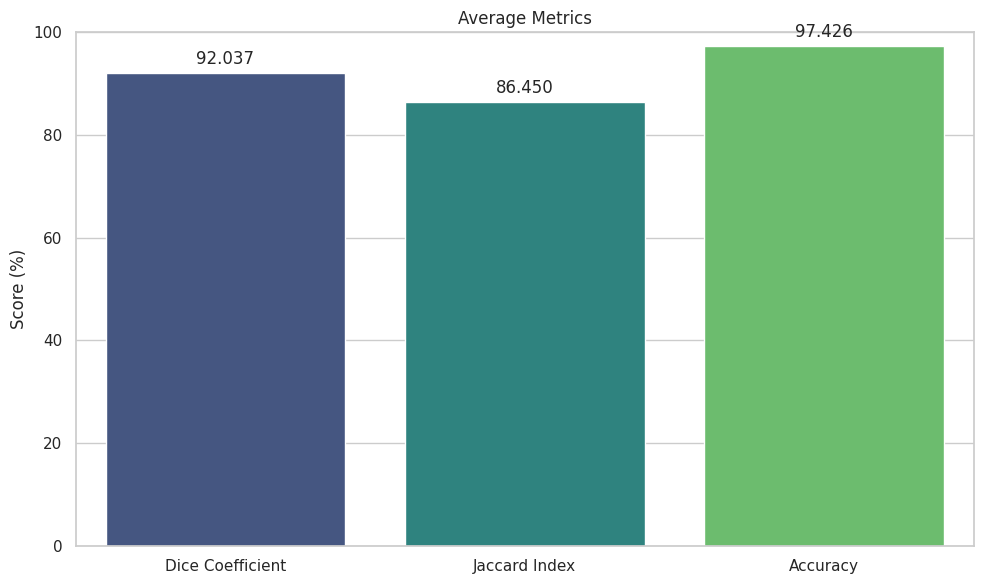

In [16]:
#Tính means :
mean_dice = np.mean(dice_scores) * 100
mean_jaccard = np.mean(jaccard_scores) * 100
mean_accuracy = np.mean(accuracy_scores) * 100

#Dữ liệu trực quan :
metrics = ['Dice Coefficient', 'Jaccard Index', 'Accuracy']
values = [mean_dice, mean_jaccard, mean_accuracy]

#Tạo biểu đồ cột :
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=metrics, y=values, palette="viridis")

#Thêm giá trị của các metric lên cột :
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

#Thiết lập labels và title :
ax.set(ylim=(0, 100))
plt.ylabel('Score (%)')
plt.title('Average Metrics')

#Hiển thị biểu đồ :
plt.tight_layout()
plt.show()

# **Hiển thị ảnh đã phân đoạn :**

In [17]:
def Show_Images_Mask_Pred(x_test, y_true, binary_predictions, qual=10):
    top_qual = np.argsort(dice_scores)[-qual:]
    
    for i in top_qual :
        plt.figure(figsize=(15, 5))

        #Hệ số Dice Coef, Jaccard, Accuracy :
        print(f'Accuracy For Image {i}: {accuracy_scores[i]}')
        print(f'Dice Coefficent For Image {i}: {dice_scores[i]}')
        print(f'Jaccard For Image {i}: {jaccard_scores[i]}')

        plt.subplot(1, 4, 1)
        plt.imshow(x_test[i][...,::-1])
        plt.title('Ảnh Thật')
        plt.axis('off')  # Bỏ grid

        plt.subplot(1, 4, 2)
        plt.imshow(y_true[i], cmap='gray')
        plt.title('Mặt Nạ Thật')
        plt.axis('off')  # Bỏ grid

            
        plt.subplot(1, 4, 3)
        plt.imshow(y_pred[i], cmap='gray')
        plt.title('Dự Đoán Chưa Áp Ngưỡng')
        plt.axis('off')  # Bỏ grid

    
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred_b[i], cmap='gray')
        plt.title('Dự Đoán Đã Áp Ngưỡng')
        plt.axis('off')  # Bỏ grid

        plt.show()
        print('='*80)

Accuracy For Image 77: 0.99615478515625
Dice Coefficent For Image 77: 0.9801876544952393
Jaccard For Image 77: 0.96093628894745


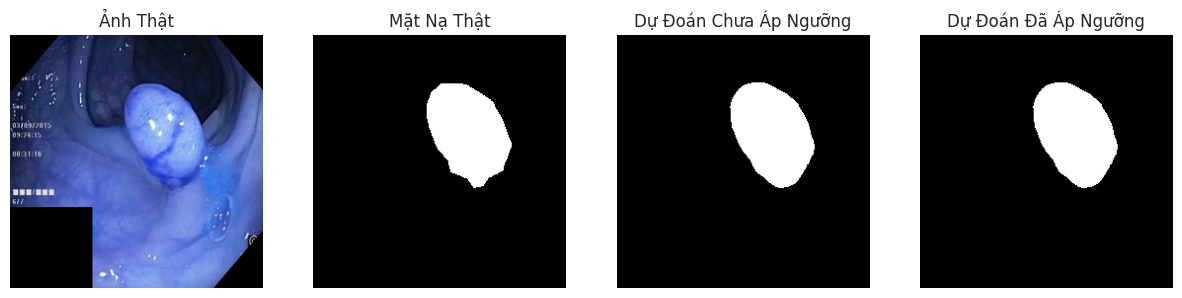

Accuracy For Image 17: 0.991485595703125
Dice Coefficent For Image 17: 0.9806160926818848
Jaccard For Image 17: 0.9619709670823963


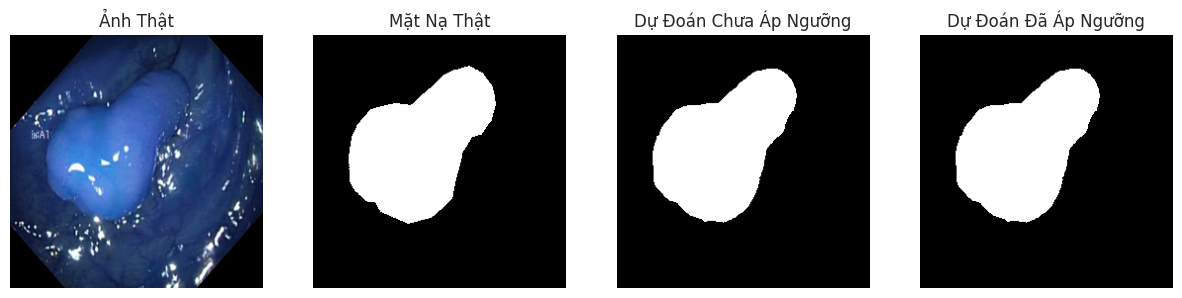

Accuracy For Image 69: 0.996002197265625
Dice Coefficent For Image 69: 0.9816691875457764
Jaccard For Image 69: 0.9640751405457287


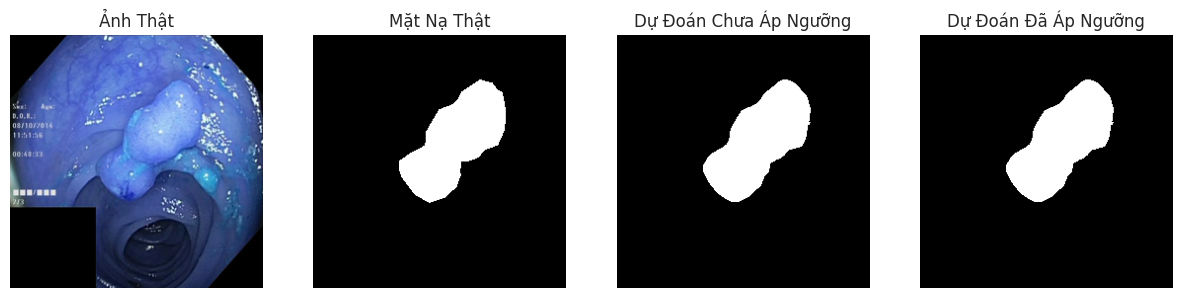

Accuracy For Image 26: 0.996337890625
Dice Coefficent For Image 26: 0.9834700226783752
Jaccard For Image 26: 0.967373572593801


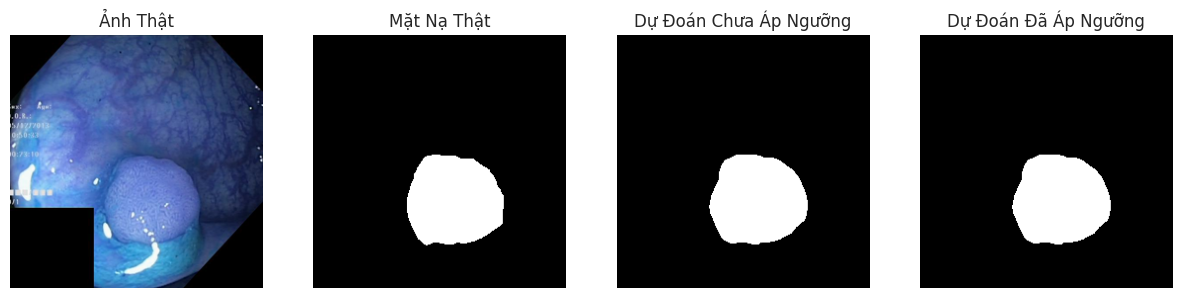

Accuracy For Image 75: 0.993072509765625
Dice Coefficent For Image 75: 0.9836894273757935
Jaccard For Image 75: 0.9678788736380359


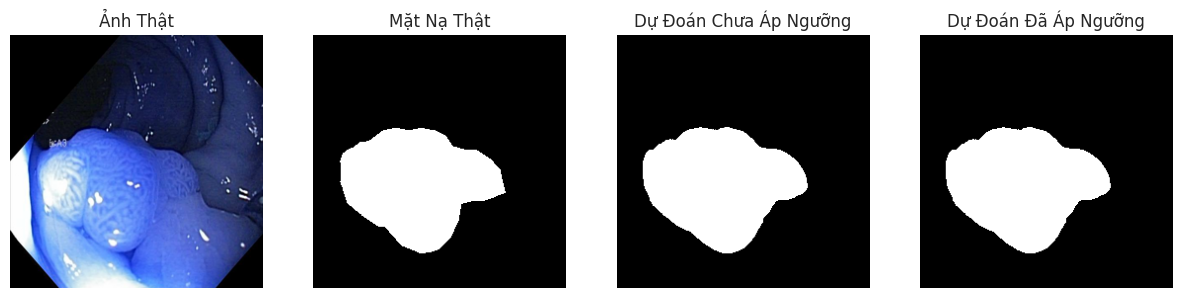

Accuracy For Image 22: 0.9917755126953125
Dice Coefficent For Image 22: 0.9856278300285339
Jaccard For Image 22: 0.9716196293176074


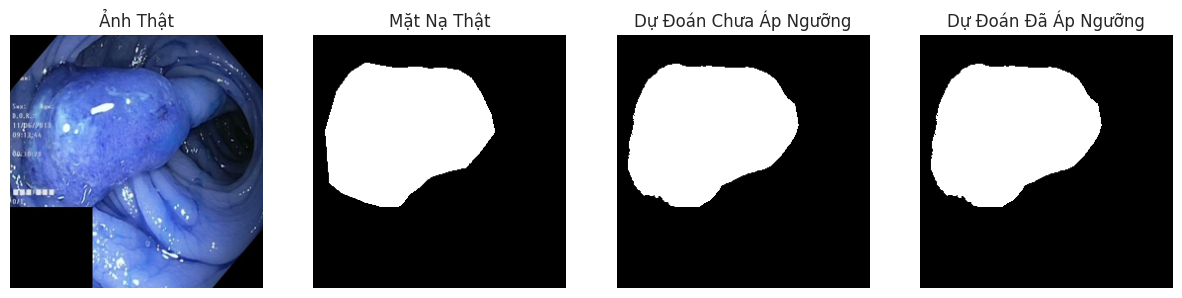

Accuracy For Image 85: 0.9921417236328125
Dice Coefficent For Image 85: 0.9872174859046936
Jaccard For Image 85: 0.9747363257297033


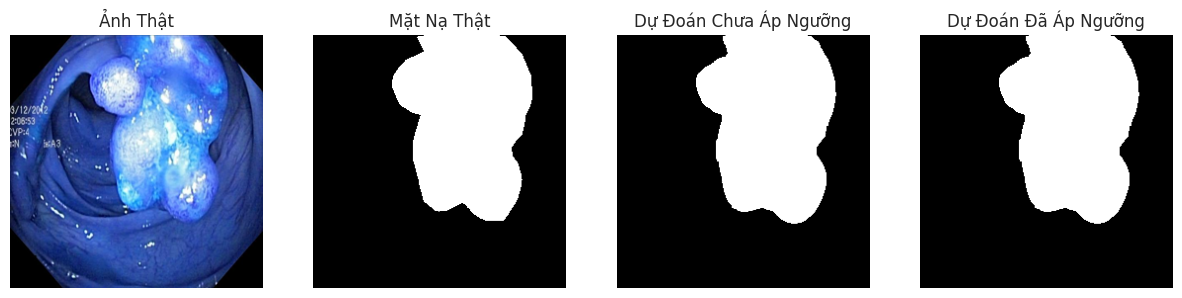

Accuracy For Image 19: 0.9932861328125
Dice Coefficent For Image 19: 0.9873798489570618
Jaccard For Image 19: 0.9752028854824166


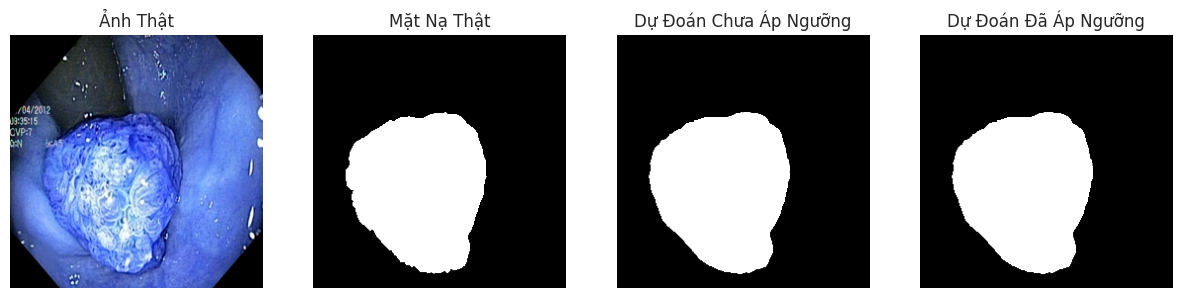

Accuracy For Image 37: 0.9935150146484375
Dice Coefficent For Image 37: 0.9889137148857117
Jaccard For Image 37: 0.9781457294184193


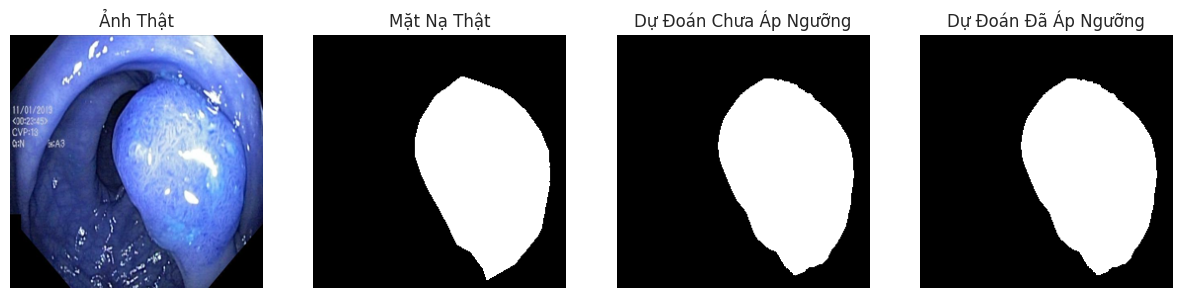

Accuracy For Image 48: 0.9971466064453125
Dice Coefficent For Image 48: 0.9905683398246765
Jaccard For Image 48: 0.9814833151797208


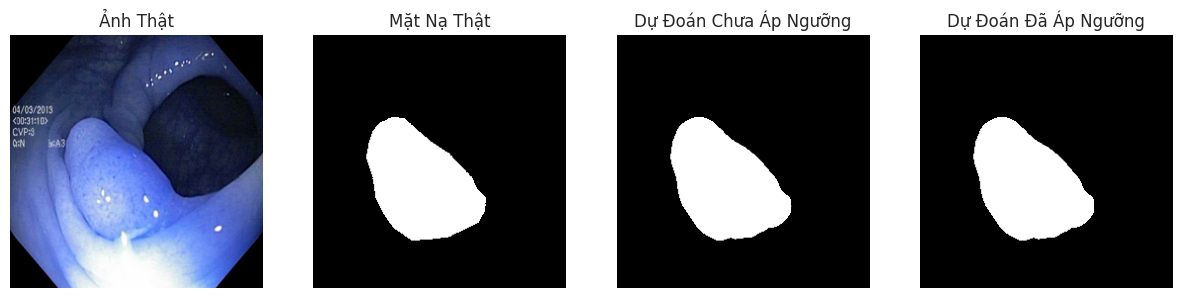

In [18]:
Show_Images_Mask_Pred(x_test , y_test, 
                      y_pred_b, 
                      qual = 10)